In [17]:
import json
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

#from load_keypoints import bodypart_index

In [18]:
# loads from saved file
with open("pose_data.jsonl") as f:
    data = [json.loads(line) for line in f if line.strip()]

In [19]:
vid_index = 0
frame_index = 0
bodypart_index = 0
data[vid_index]['keypoints'][frame_index][bodypart_index][:2]

[623.677978515625, 336.6422119140625]

In [20]:
def get_positions(data, video_index):
    video_entry = data[video_index]
    gesture_id = video_entry['gesture_id']
    keypoints = np.array(video_entry['keypoints'])
    keypoints = keypoints[:, :, :2]
    return keypoints

In [21]:
def get_velocitys(data, video_index):
    video_entry = data[video_index]
    gesture_id = video_entry['gesture_id']
    keypoints = np.array(video_entry['keypoints'])
    keypoints = keypoints[:, :, :2]

    velocities = np.diff(keypoints, axis=0)
    return velocities

In [22]:
def get_position_velocity(data, video_index):
    positions = get_positions(data, video_index)
    velocities = get_velocitys(data, video_index)

    merged = np.concatenate([positions[:-1], velocities], axis=-1)
    return merged

In [23]:
for i in range(0, len(data)):
    keypoints = data[i]['keypoints']
    gesture_id = data[i]['gesture_id']

    if keypoints:
        X = get_position_velocity(data, i)
        Y = gesture_id

In [24]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import random
# -------------------------
# Dataset definition
# -------------------------
class PoseGestureDataset(Dataset):
    def __init__(self, data, get_position_velocity_fn):
        """
        Args:
            data: list of dicts, each like {'keypoints': ..., 'gesture_id': ...}
            get_position_velocity_fn: function(data, i) -> torch.Tensor or np.ndarray
        """
        self.samples = []
        for i in range(len(data)):
            keypoints = data[i].get('keypoints')
            gesture_id = data[i].get('gesture_id')

            if keypoints:
                X = get_position_velocity_fn(data, i)  # (Ni, 17, 4)
                Y = gesture_id
                if isinstance(X, np.ndarray):
                    X = torch.tensor(X, dtype=torch.float32)
                self.samples.append((X, Y))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        X, Y = self.samples[idx]
        X = X.view(X.shape[0], -1)  # flatten to (Ni, 68)
        return X, torch.tensor(Y, dtype=torch.long)

    # shuffle the samples
    def shuffle(self, seed = 42):
        random.seed(seed)
        self.samples = random.sample(self.samples, len(self.samples))


/Users/nickaloyd/Library/Python/3.10/lib/python/site-packages/torch/utils/_pytree.py:185: FutureWarning: optree is installed but the version is too old to support PyTorch Dynamo in C++ pytree. C++ pytree support is disabled. Please consider upgrading optree using `python3 -m pip install --upgrade 'optree>=0.13.0'`.
  warnings.warn(


In [25]:
# -------------------------
# Collate function for variable-length sequences
# -------------------------
def pad_collate_fn(batch):
    sequences = [item[0] for item in batch]
    labels = torch.tensor([item[1] for item in batch], dtype=torch.long)
    lengths = [seq.shape[0] for seq in sequences]

    padded_X = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True)
    return padded_X, labels, torch.tensor(lengths, dtype=torch.long)


def get_position_velocity(data, i):
    N = np.random.randint(50, 150)  # random number of frames
    return np.random.rand(N, 17, 4)

# -------------------------
# Example usage
# -------------------------
# Create dataset and dataloader
dataset = PoseGestureDataset(data, get_position_velocity)
dataset.shuffle(seed = 10)

loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=pad_collate_fn
)

# Inspect one batch
for X, Y, lengths in loader:
    print("Batch X shape:", X.shape)   # (batch_size, max_seq_len, 68)
    print("Batch Y shape:", Y.shape)   # (batch_size,)
    print("Sequence lengths:", lengths)

    print(X)
    print(Y)
    break

Batch X shape: torch.Size([2, 115, 68])
Batch Y shape: torch.Size([2])
Sequence lengths: tensor([ 50, 115])
tensor([[[0.4400, 0.8172, 0.0244,  ..., 0.0567, 0.1300, 0.5201],
         [0.3040, 0.0349, 0.0237,  ..., 0.2688, 0.6536, 0.8453],
         [0.3534, 0.9404, 0.3177,  ..., 0.6527, 0.7681, 0.9104],
         ...,
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.6723, 0.1896, 0.6512,  ..., 0.7435, 0.6517, 0.1155],
         [0.2572, 0.7196, 0.1421,  ..., 0.0970, 0.6159, 0.0509],
         [0.0309, 0.7980, 0.9495,  ..., 0.3354, 0.7556, 0.1930],
         ...,
         [0.3894, 0.9307, 0.6438,  ..., 0.0646, 0.6773, 0.8596],
         [0.9412, 0.8935, 0.3766,  ..., 0.0485, 0.6334, 0.8161],
         [0.3450, 0.3964, 0.1058,  ..., 0.5526, 0.6638, 0.1212]]])
tensor([5, 8])


In [26]:
from torch.utils.data import DataLoader, random_split

# ----- Dataset -----
dataset = PoseGestureDataset(data, get_position_velocity)

# ----- Split -----
total_len = len(dataset)
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
train_len = int(total_len * train_ratio)
val_len = int(total_len * val_ratio)
test_len = total_len - train_len - val_len

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# ----- DataLoaders with padding collate_fn -----
batch_size = 8

train_loader = DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn
)
val_loader = DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn
)
test_loader = DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, collate_fn=pad_collate_fn
)

# ----- Verify -----
for X, Y, lengths in train_loader:
    print("Train batch X shape:", X.shape)
    print("Train batch Y shape:", Y.shape)
    print("Sequence lengths:", lengths)
    break

Train batch X shape: torch.Size([8, 138, 68])
Train batch Y shape: torch.Size([8])
Sequence lengths: tensor([105, 100, 121, 138, 104,  57,  71,  75])


In [27]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split

# -------------------------
# Assume dataset and pad_collate_fn are already defined
# and train_loader, val_loader, test_loader exist
# -------------------------

# ----- Bi-LSTM Model -----
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_size=68, hidden_size=128, num_layers=2, num_classes=3):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True
        )
        self.fc = nn.Linear(hidden_size * 2, num_classes)  # *2 for bidirectional

    def forward(self, x, lengths):
        # Pack padded sequences
        packed = nn.utils.rnn.pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_out, (hn, cn) = self.lstm(packed)
        # Concatenate last hidden states from both directions
        out = torch.cat((hn[-2], hn[-1]), dim=1)  # shape: (batch, hidden*2)
        out = self.fc(out)
        return out

# ----- Training Setup -----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_classes = len(set([data[i]['gesture_id'] for i in range(len(data)) if data[i]['keypoints']]))
model = BiLSTMClassifier(num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# ----- Training Loop -----
num_epochs = 50  # adjust as needed

for epoch in range(num_epochs):
    model.train()
    total_correct = 0
    total_samples = 0
    total_loss = 0

    for X, Y, lengths in train_loader:
        X, Y, lengths = X.to(device), Y.to(device), lengths.to(device)

        optimizer.zero_grad()
        outputs = model(X, lengths)

        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Y.size(0)
        preds = outputs.argmax(dim=1)
        total_correct += (preds == Y).sum().item()
        total_samples += Y.size(0)

    train_acc = total_correct / total_samples
    train_loss = total_loss / total_samples

    # ----- Validation -----
    model.eval()
    val_correct = 0
    val_samples = 0
    with torch.no_grad():
        for X_val, Y_val, lengths_val in val_loader:
            X_val, Y_val, lengths_val = X_val.to(device), Y_val.to(device), lengths_val.to(device)
            outputs_val = model(X_val, lengths_val)
            preds_val = outputs_val.argmax(dim=1)
            val_correct += (preds_val == Y_val).sum().item()
            val_samples += Y_val.size(0)

    val_acc = val_correct / val_samples

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc*100:.2f}% | "
          f"Val Acc: {val_acc*100:.2f}%")

Epoch 1/50 | Train Loss: 2.3101, Train Acc: 9.55% | Val Acc: 8.61%
Epoch 2/50 | Train Loss: 2.3038, Train Acc: 9.90% | Val Acc: 7.79%
Epoch 3/50 | Train Loss: 2.3034, Train Acc: 9.90% | Val Acc: 11.48%
Epoch 4/50 | Train Loss: 2.2989, Train Acc: 11.57% | Val Acc: 9.02%
Epoch 5/50 | Train Loss: 2.2962, Train Acc: 12.36% | Val Acc: 7.38%
Epoch 6/50 | Train Loss: 2.2855, Train Acc: 13.06% | Val Acc: 9.02%
Epoch 7/50 | Train Loss: 2.2486, Train Acc: 16.21% | Val Acc: 9.02%
Epoch 8/50 | Train Loss: 2.1716, Train Acc: 20.33% | Val Acc: 11.07%
Epoch 9/50 | Train Loss: 2.0724, Train Acc: 24.63% | Val Acc: 9.02%
Epoch 10/50 | Train Loss: 1.9237, Train Acc: 31.20% | Val Acc: 9.43%
Epoch 11/50 | Train Loss: 1.6897, Train Acc: 40.75% | Val Acc: 10.25%
Epoch 12/50 | Train Loss: 1.3779, Train Acc: 53.02% | Val Acc: 12.30%
Epoch 13/50 | Train Loss: 0.9918, Train Acc: 69.33% | Val Acc: 12.70%
Epoch 14/50 | Train Loss: 0.5665, Train Acc: 84.49% | Val Acc: 9.43%
Epoch 15/50 | Train Loss: 0.2464, Train A

In [28]:
# ----- Test Accuracy -----
model.eval()
test_correct = 0
test_samples = 0
with torch.no_grad():
    for X_test, Y_test, lengths_test in test_loader:
        X_test, Y_test, lengths_test = X_test.to(device), Y_test.to(device), lengths_test.to(device)
        outputs_test = model(X_test, lengths_test)
        preds_test = outputs_test.argmax(dim=1)
        test_correct += (preds_test == Y_test).sum().item()
        test_samples += Y_test.size(0)

test_acc = test_correct / test_samples
print(f"Test Accuracy: {test_acc*100:.2f}%")

Test Accuracy: 9.80%


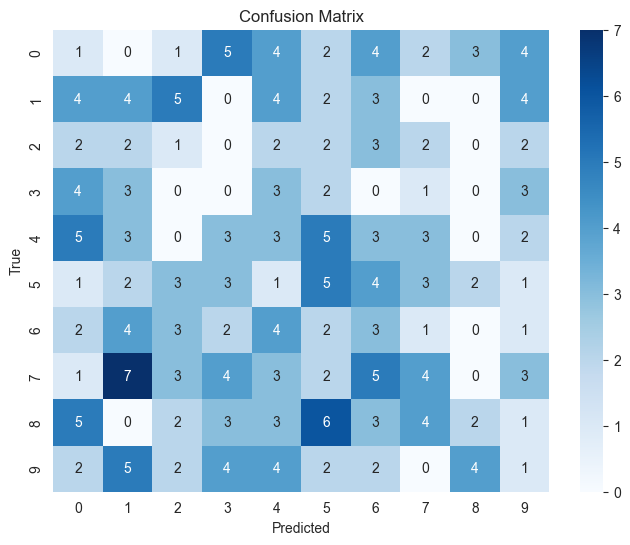

In [29]:
import torch
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# ----- Make predictions on test set -----
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for X_test, Y_test, lengths_test in test_loader:
        X_test, Y_test, lengths_test = X_test.to(device), Y_test.to(device), lengths_test.to(device)
        outputs = model(X_test, lengths_test)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(Y_test.cpu().numpy())

# ----- Compute confusion matrix -----
cm = confusion_matrix(all_labels, all_preds)

# ----- Plot -----
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()